In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#  Packages & Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import sklearn as skl
import warnings
import statsmodels.api as sm

from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, validation_curve, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler, LabelEncoder, scale, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.feature_selection import RFE,SelectFromModel

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.datasets import make_classification

from xgboost import XGBClassifier 

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore')


In [3]:
#Load Datasets
train_data = pd.read_csv("training_set_values.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_data = pd.read_csv("test_set_values.csv")


In [4]:
#Join Labels with Train data
train_labels = train_labels.drop(columns='id')
train_data = train_data.join(train_labels)


In [9]:
#Drop id and recorded from train dataset 
train_data= train_data.drop(columns=['id'])
train_data= train_data.drop(columns=['recorded_by'])


In [10]:
#Drop id and recorded from test dataset 
test_data= test_data.drop(columns=['id'])
test_data= test_data.drop(columns=['recorded_by'])

In [11]:
# Differentiate categorical from numerical variables, even though some are encoded already,
num_train_data = train_data[[
# 'id',
'amount_tsh',
'gps_height',
'num_private',
'population',
]]

other_train_data = train_data[[ 
'longitude',
'latitude',
'date_recorded',
]]
    
categorical_columns = list(set(train_data.columns) - set(num_train_data.columns) - set(other_train_data.columns))
cat_train_data = train_data.loc[:,categorical_columns]


# Data Preparation Proposals
Keeping all transformations in the same cell in an effort to make easy to recreate all steps for the Test set

In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
scheme_management        55523 non-null object


In [54]:
train_data['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

Transform Training Dataset

In [55]:
train_temp = train_data.copy()

# installer - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['DWE', 'Government','RWE','Commu','DANIDA']):
        return x
    else:
        return 'other'
train_temp.installer = train_temp.installer.map(replace)

# funder - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['Government Of Tanzania',
'Danida',
'Hesawa',
'Rwssp',
'World Bank',
'Kkkt',
'World Vision',
'Unicef',
'Tasaf',
'District Council']):
        return x
    else:
        return 'other'
train_temp.funder = train_temp.funder.map(replace)

# lga - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['Njombe',
'Arusha Rural',
'Moshi Rural',
'Bariadi',
'Rungwe',
'Kilosa',
'Kasulu',
'Mbozi',
'Meru',
'Bagamoyo']):
        return x
    else:
        return 'other'
train_temp.lga = train_temp.lga.map(replace)


#Eliminate scheme_name from the dataset.
train_temp= train_temp.drop(columns=['scheme_name'])

# Eliminate ward from dataset
train_temp= train_temp.drop(columns=['ward'])

# Eliminate wpt_name from dataset#
train_temp= train_temp.drop(columns=['wpt_name'])

# Eliminate subvillage from dataset#
train_temp= train_temp.drop(columns=['subvillage'])

#Choose Between Region and Region_Code and District Code
#train_temp= train_temp.drop(columns=['region'])
#train_temp= train_temp.drop(columns=['region_code'])
#train_temp= train_temp.drop(columns=['district_code'])

#Construction Year, Bin values per decade --- Note: that (-1, 1960] is the same as Unknown
year_bins = [-1, 1960, 1990, 2015]
train_temp['construction_year_bin'] = pd.cut(train_temp.construction_year,year_bins)
train_temp['construction_year_bin'] = train_temp["construction_year_bin"].astype('category') 
train_temp= train_temp.drop(columns=['construction_year'])

#how to treat, date_recorded?
train_temp.date_recorded = pd.to_datetime(train_temp.date_recorded)
train_temp.date_recorded = pd.to_datetime(train_temp.date_recorded)
train_temp.date_recorded = pd.datetime(2014, 1, 1) - pd.to_datetime(train_temp.date_recorded)
train_temp.columns = ['days_since_recorded' if x=='date_recorded' else x for x in train_temp.columns]
train_temp.days_since_recorded = train_temp.days_since_recorded.astype('timedelta64[D]').astype(int)

recorded_bins = [1, 500, 1000, 2000, 4100]
train_temp['days_since_recorded_bin'] = pd.cut(train_temp.days_since_recorded,recorded_bins)
train_temp['days_since_recorded_bin'] = train_temp["days_since_recorded_bin"].astype('category') 

#Is longitude and Latitude relevant to the model
# train_temp= train_temp.drop(columns=['longitude'])
# train_temp= train_temp.drop(columns=['latitude'])

#Decide between waterpoint_type & waterpoint_type_group
# train_temp= train_temp.drop(columns=['waterpoint_type'])
# train_temp= train_temp.drop(columns=['waterpoint_type_group'])

#Decide between extraction_type & extraction_type_group & extraction_type_class
# train_temp= train_temp.drop(columns=['extraction_type'])
# train_temp= train_temp.drop(columns=['extraction_type_group'])
# train_temp= train_temp.drop(columns=['extraction_type_class'])



Transform Test Dataset

In [56]:
test_temp = test_data.copy()

# installer - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['DWE', 'Government','RWE','Commu','DANIDA']):
        return x
    else:
        return 'other'
test_temp.installer = test_temp.installer.map(replace)

# funder - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['Government Of Tanzania',
'Danida',
'Hesawa',
'Rwssp',
'World Bank',
'Kkkt',
'World Vision',
'Unicef',
'Tasaf',
'District Council']):
        return x
    else:
        return 'other'
test_temp.funder = test_temp.funder.map(replace)

# lga - shortlist of the 5 higher and category other, note that nulls will be included in this criteria.
def replace(x):
    if x in list(['Njombe',
'Arusha Rural',
'Moshi Rural',
'Bariadi',
'Rungwe',
'Kilosa',
'Kasulu',
'Mbozi',
'Meru',
'Bagamoyo']):
        return x
    else:
        return 'other'
test_temp.lga = test_temp.lga.map(replace)


#Eliminate scheme_name from the dataset.
test_temp= test_temp.drop(columns=['scheme_name'])

# Eliminate ward from dataset
test_temp= test_temp.drop(columns=['ward'])

# Eliminate wpt_name from dataset#
test_temp= test_temp.drop(columns=['wpt_name'])

# Eliminate subvillage from dataset#
test_temp= test_temp.drop(columns=['subvillage'])

#Choose Between Region and Region_Code and District Code
#test_temp= test_temp.drop(columns=['region'])
#test_temp= test_temp.drop(columns=['region_code'])
#test_temp= test_temp.drop(columns=['district_code'])

#Construction Year, Bin values per decade --- Note: that (-1, 1960] is the same as Unknown
year_bins = [-1, 1960, 1990, 2015]
test_temp['construction_year_bin'] = pd.cut(test_temp.construction_year,year_bins)
test_temp['construction_year_bin'] = test_temp["construction_year_bin"].astype('category') 
test_temp= test_temp.drop(columns=['construction_year'])

#how to treat, date_recorded?
test_temp.date_recorded = pd.to_datetime(test_temp.date_recorded)
test_temp.date_recorded = pd.to_datetime(test_temp.date_recorded)
test_temp.date_recorded = pd.datetime(2014, 1, 1) - pd.to_datetime(test_temp.date_recorded)
test_temp.columns = ['days_since_recorded' if x=='date_recorded' else x for x in test_temp.columns]
test_temp.days_since_recorded = test_temp.days_since_recorded.astype('timedelta64[D]').astype(int)

recorded_bins = [1, 500, 1000, 2000, 4100]
test_temp['days_since_recorded_bin'] = pd.cut(test_temp.days_since_recorded,recorded_bins)
test_temp['days_since_recorded_bin'] = test_temp["days_since_recorded_bin"].astype('category') 

#Is longitude and Latitude relevant to the model
# test_temp= test_temp.drop(columns=['longitude'])
# test_temp= test_temp.drop(columns=['latitude'])

#Decide between waterpoint_type & waterpoint_type_group
# test_temp= test_temp.drop(columns=['waterpoint_type'])
# test_temp= test_temp.drop(columns=['waterpoint_type_group'])

#Decide between extraction_type & extraction_type_group & extraction_type_class
# test_temp= test_temp.drop(columns=['extraction_type'])
# test_temp= test_temp.drop(columns=['extraction_type_group'])
# test_temp= test_temp.drop(columns=['extraction_type_class'])



Transform Train Data types

In [57]:
train_temp['district_code'] = train_temp["district_code"].astype('category') 
train_temp['region_code'] = train_temp["region_code"].astype('category') 
#target = train_temp[['status_group']]
#train_temp['status_group'] = train_temp["status_group"].astype('category') 

train_temp['funder'] = train_temp["funder"].astype('category') 
train_temp['installer'] = train_temp["installer"].astype('category') 
train_temp['lga'] = train_temp["lga"].astype('category') 

Transform Test Data types

In [58]:
test_temp['district_code'] = test_temp["district_code"].astype('category') 
test_temp['region_code'] = test_temp["region_code"].astype('category') 
#target = test_temp[['status_group']]
#test_temp['status_group'] = test_temp["status_group"].astype('category') 

test_temp['funder'] = test_temp["funder"].astype('category') 
test_temp['installer'] = test_temp["installer"].astype('category') 
test_temp['lga'] = test_temp["lga"].astype('category') 

In [59]:
len(test_temp.columns)

35

In [60]:
len(train_temp.columns)

36

In [61]:
# # Differentiate categorical from numerical variables

# target = train_temp[['status_group']]

# num_train_temp = train_temp[[
# 'amount_tsh',
# 'gps_height',
# 'num_private',
# 'population',
# 'days_since_recorded']]

# #Other are those fields under review that require further discussion
# other_train_temp = train_temp[[ 
# 'longitude',
# 'latitude',
# 'funder',
# 'lga',
# 'installer',
# ]]
    
# categorical_columns = list(set(train_temp.columns) - set(num_train_temp.columns) - set(other_train_temp.columns))
# cat_train_temp = train_temp.loc[:,categorical_columns]


In [62]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

# Data Preparation Exploratory Analysis

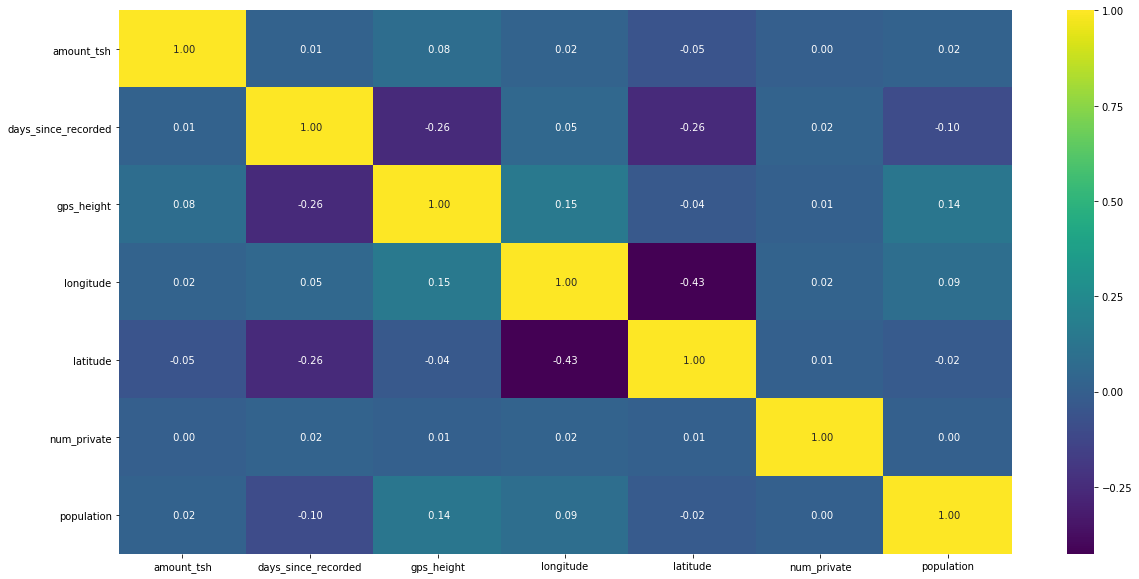

In [64]:
plt.pyplot.figure(figsize=(20,10))
sns.heatmap(train_temp.corr(),cbar=True,fmt =' .2f', annot=True, cmap='viridis')

Text(0, 0.5, 'Percentage')

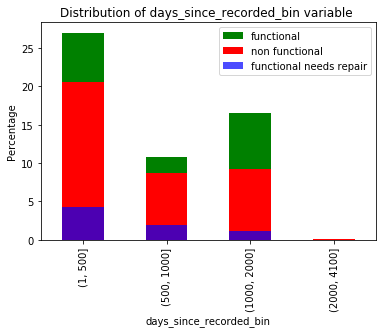

In [65]:
plt.pyplot.show()
ax = ((train_temp[train_temp.status_group=='functional'].days_since_recorded_bin.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='g', x='days_since_recorded_bin')
((train_temp[train_temp.status_group=='non functional'].days_since_recorded_bin.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='r', x='days_since_recorded_bin')
((train_temp[train_temp.status_group=='functional needs repair'].days_since_recorded_bin.value_counts().sort_index()/len(train_temp.status_group)*100)).plot(kind='bar',color='b',alpha= 0.7, ax= ax, x='days_since_recorded_bin')
ax.legend(["functional", "non functional","functional needs repair"])
plt.pyplot.title('Distribution of days_since_recorded_bin variable ')
plt.pyplot.xlabel('days_since_recorded_bin')
plt.pyplot.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

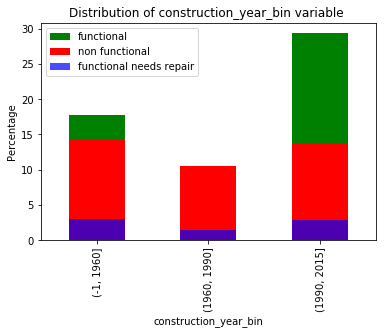

In [66]:
plt.pyplot.show()
ax = ((train_temp[train_temp.status_group=='functional'].construction_year_bin.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='g', x='construction_year_bin')
((train_temp[train_temp.status_group=='non functional'].construction_year_bin.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='r', x='construction_year_bin')
((train_temp[train_temp.status_group=='functional needs repair'].construction_year_bin.value_counts().sort_index()/len(train_temp.status_group)*100)).plot(kind='bar',color='b',alpha= 0.7, ax= ax, x='construction_year_bin')
ax.legend(["functional", "non functional","functional needs repair"])
plt.pyplot.title('Distribution of construction_year_bin variable ')
plt.pyplot.xlabel('construction_year_bin')
plt.pyplot.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

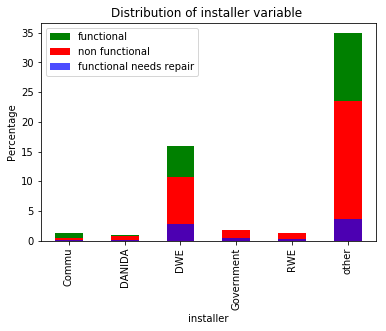

In [67]:
plt.pyplot.show()
ax = ((train_temp[train_temp.status_group=='functional'].installer.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='g', x='installer')
((train_temp[train_temp.status_group=='non functional'].installer.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='r', x='installer')
((train_temp[train_temp.status_group=='functional needs repair'].installer.value_counts().sort_index()/len(train_temp.status_group)*100)).plot(kind='bar',color='b',alpha= 0.7, ax= ax, x='installer')
ax.legend(["functional", "non functional","functional needs repair"])
plt.pyplot.title('Distribution of installer variable ')
plt.pyplot.xlabel('installer')
plt.pyplot.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

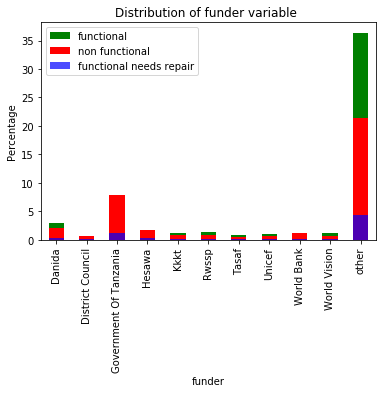

In [68]:
plt.pyplot.show()
ax = ((train_temp[train_temp.status_group=='functional'].funder.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='g', x='funder')
((train_temp[train_temp.status_group=='non functional'].funder.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='r', x='funder')
((train_temp[train_temp.status_group=='functional needs repair'].funder.value_counts().sort_index()/len(train_temp.status_group)*100)).plot(kind='bar',color='b',alpha= 0.7, ax= ax, x='funder')
ax.legend(["functional", "non functional","functional needs repair"])
plt.pyplot.title('Distribution of funder variable ')
plt.pyplot.xlabel('funder')
plt.pyplot.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

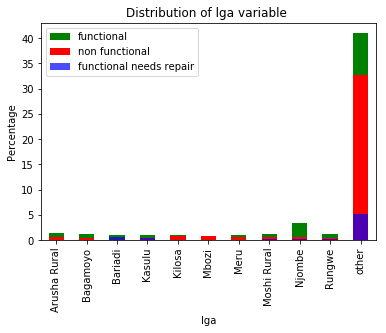

In [69]:
plt.pyplot.show()
ax = ((train_temp[train_temp.status_group=='functional'].lga.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='g', x='lga')
((train_temp[train_temp.status_group=='non functional'].lga.value_counts().sort_index()/len(train_temp.status_group))*100).plot(kind='bar',color='r', x='lga')
((train_temp[train_temp.status_group=='functional needs repair'].lga.value_counts().sort_index()/len(train_temp.status_group)*100)).plot(kind='bar',color='b',alpha= 0.7, ax= ax, x='lga')
ax.legend(["functional", "non functional","functional needs repair"])
plt.pyplot.title('Distribution of lga variable ')
plt.pyplot.xlabel('lga')
plt.pyplot.ylabel('Percentage')

# Save Data